In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import plotly.graph_objects as go

In [2]:
from src.datasets.datamodules import ActsDataModule
from src.my_model.transformer import *

In [3]:
# Instantiate the DataModule num_workers=16)
dataset_wrapper = ActsDataModule()

dataset_wrapper.setup()
tl = dataset_wrapper.test_dataloader()

───────────────────────────────────────── ACTS Streamlined Preprocessing ──────────────────────────────────────────

In [12]:
# Load models
mse_trans_tml = "Data/Tb/model-epoch=11-val_loss=8.41-v1.ckpt"
qloss_tml_trasf = "Data/Tb/model-epoch=04-val_loss=0.81.ckpt"
transf_mse_model = TrackFormer.load_from_checkpoint(mse_trans_tml)
transf_mse_model.eval().to("cpu")

qloss_transf_tt_model = TrackFormer.load_from_checkpoint(qloss_tml_trasf)
qloss_transf_tt_model.eval().to("cpu")

bad_tracks_q = []
bad_tracks_mse = []

relative_errors_mse = []
relative_errors_qloss = []

errors_mse = []
errors_qloss = []


with torch.no_grad():
    for i, (input, mask, target) in enumerate(tqdm(tl)):
        
        # Transformers
        pt_pred_mse = transf_mse_model(input)[:, 0]
        pt_pred_qloss = qloss_transf_tt_model(input)[:, 0]
        pt_true = target[:, 0]

        error_mse = abs(pt_true - pt_pred_mse)
        error_qloss = abs(pt_true - pt_pred_qloss)

        errors_mse.extend(error_mse.tolist())

        relative_error_mse = error_mse / pt_true
        relative_error_qloss = error_qloss / pt_true

        if (relative_error_mse > 10).any():
            mask_ = relative_error_mse > 10
            selected = input[mask_][0]
            
            
            error_values = error_mse[mask_].tolist()
            pt_values = pt_true[mask_].tolist()
            bad_tracks_mse.extend(((error, pt), selected) for error, pt in zip(error_values, pt_values))

        if (relative_error_qloss > 10).any():
            mask_ = relative_error_qloss > 10
            selected = input[mask_][0]
            
            error_values = error_qloss[mask_].tolist()
            pt_values = pt_true[mask_].tolist()
            bad_tracks_q.extend(((error, pt), selected) for error, pt in zip(error_values, pt_values))

        relative_errors_mse.extend(relative_error_mse.tolist())
        relative_errors_qloss.extend(relative_error_qloss.tolist())



0it [00:00, ?it/s]

In [5]:
def view_trajectory(inputs, mask=None):
    """
    Plots the trajectory of a particle in 3D.
    """
    
    if mask is None:
            # Filter out zero rows
            inputs = inputs[(inputs != 0).any(dim=1)]

    else:
        inputs = inputs[mask]

    x = inputs[:, 0].numpy()
    y = inputs[:, 1].numpy()
    z = inputs[:, 2].numpy()

    fig = go.Figure(data=[go.Scatter3d(
        x=x, y=y, z=z,
        mode='lines+markers',
        marker=dict(size=4, color='blue', opacity=0.8),
        line=dict(color='blue', width=2)
    )])

    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title='Particle Trajectory'
    )

    fig.show()


In [17]:
i = 5
view_trajectory(bad_tracks_q[i][1])

In [7]:
thing = bad_tracks_q[i][1][(bad_tracks_q[i][1] != 0).any(dim=1)][:,:2]

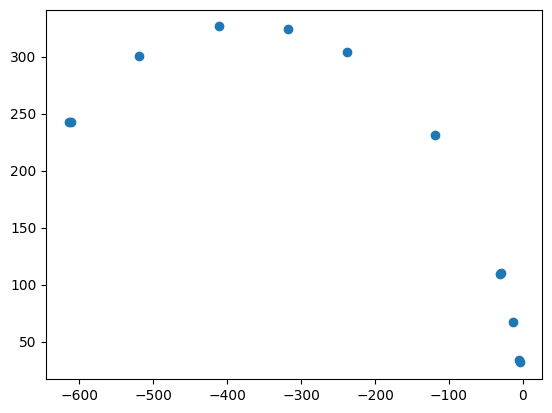

In [8]:
plt.scatter(thing[:,0],thing[:,1])

In [ ]:
from src.my_model.benchmarks import CircleFit



cf = CircleFit()


f"circle pred: {cf.fit(thing.unsqueeze(0)).item():.2f} \t true{}"

'circle pred: 376.37'

In [29]:
bad_tracks_q[i][0][1]

0.16174544394016266

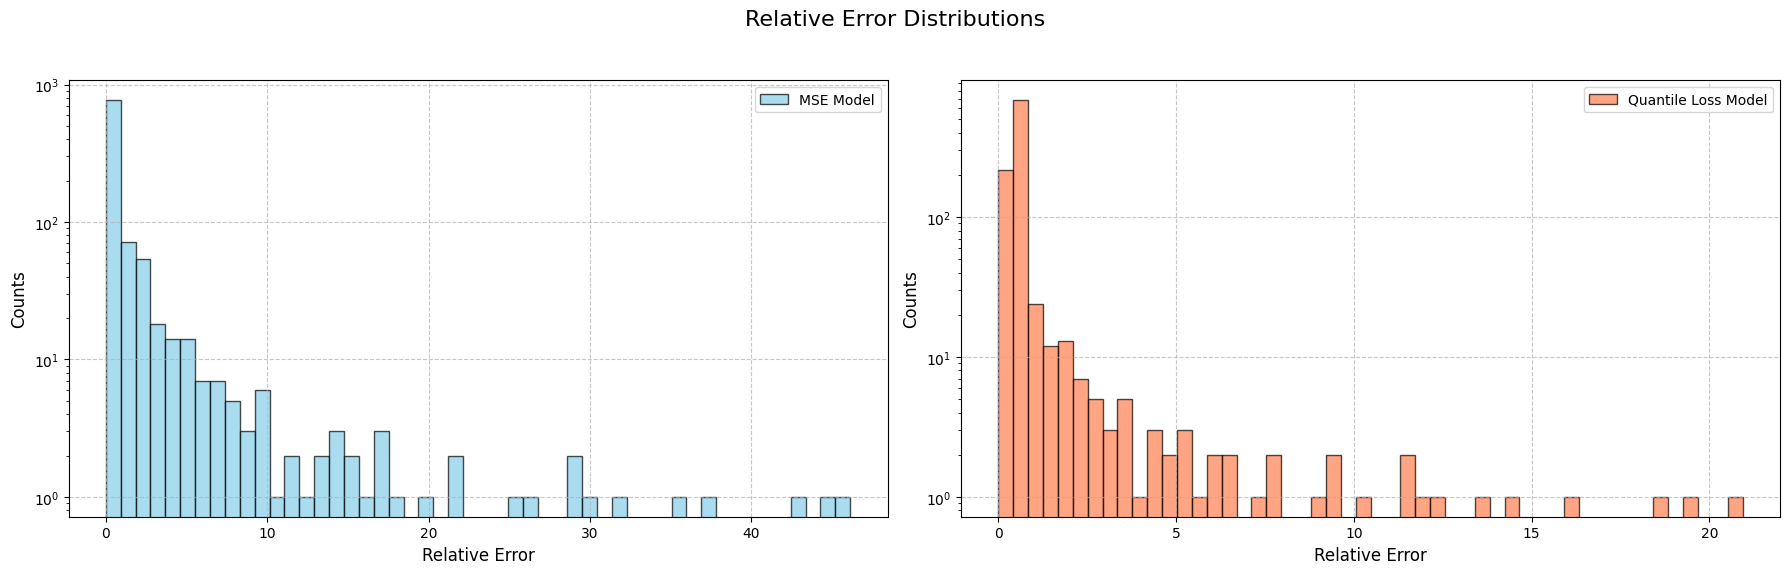

<Figure size 640x480 with 0 Axes>

In [13]:
plt.figure(figsize=(18, 6))
plt.suptitle('Relative Error Distributions', fontsize=16)

# MSE Model
plt.subplot(1, 2, 1)
plt.hist(relative_errors_mse, bins=50, alpha=0.7, label='MSE Model', color='skyblue', edgecolor='black')
plt.xlabel('Relative Error', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Qloss
plt.subplot(1, 2, 2)
plt.hist(relative_errors_qloss, bins=50, alpha=0.7, label='Quantile Loss Model', color='coral', edgecolor='black')
plt.xlabel('Relative Error', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.savefig('relative_error_distributions.png', format='png')

In [11]:
bad_tracks_q[i][0]

(4.72690486907959, 0.229966938495636)